In [1]:
import os
import pydicom
from PIL import Image
import numpy as np
import tensorflow as tf
import logging
from sklearn.model_selection import train_test_split

logging.basicConfig(level=logging.INFO)


In [2]:
import os
import pydicom
from pydicom.errors import InvalidDicomError

def get_dicom_image_size(filepath):
    if not os.path.exists(filepath):
        print(f"File does not exist: {filepath}")
        return None
    
    try:
        # Load the DICOM file
        dicom_file = pydicom.dcmread(filepath)
        
        # Retrieve dimensions
        rows = dicom_file.Rows
        columns = dicom_file.Columns
        
        return (rows, columns)
    except InvalidDicomError:
        print("Not a valid DICOM file.")
        return None
    except AttributeError:
        print("DICOM file does not contain image size information.")
        return None

# Specify the path to your DICOM file
path_to_dicom = "/Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/MRI-US-PatientImages/manifest-1706813151803/Prostate-MRI-US-Biopsy/Prostate-MRI-US-Biopsy-0001/06-28-2009-NA-MRI PROSTATE W WO CONTRAST-51743/11.000000-t2spcrstaxial oblProstate-90221/1-01.dcm"

# Get the size of the DICOM image
size = get_dicom_image_size(path_to_dicom)
if size:
    print(f"Image Size: {size[0]} x {size[1]} pixels")


Image Size: 256 x 256 pixels


In [2]:
def load_dicom_image(path, img_size=256, use_rgb=False):
    try:
        dicom = pydicom.dcmread(path)
        image = dicom.pixel_array
        image = Image.fromarray(image)
        image = image.resize((img_size, img_size))
        image = np.array(image) / 255.0  # Normalize the image
        return tf.convert_to_tensor(image, dtype=tf.float32)
    except Exception as e:
        logging.error(f"Failed to process image {path}: {e}")
        return None


In [3]:
def process_patient_images(patient_folder, img_size=256):
    images = []
    try:
        for filename in os.listdir(patient_folder):
            if filename.endswith('.dcm'):
                path = os.path.join(patient_folder, filename)
                image = load_dicom_image(path, img_size=img_size)
                if image is not None:
                    images.append(image)
    except Exception as e:
        logging.warning(f"Error processing folder {patient_folder}: {e}")
    return images

In [4]:
def process_data(folders, img_size, batch_size):
    all_images = []
    all_labels = []
    for folder_path, label in folders:
        images = process_patient_images(folder_path, img_size=img_size)
        all_images.extend(images)
        all_labels.extend([label] * len(images))
    
    dataset_images = tf.stack(all_images)
    dataset_labels = tf.convert_to_tensor(all_labels, dtype=tf.float32)
    dataset = tf.data.Dataset.from_tensor_slices((dataset_images, dataset_labels)).shuffle(buffer_size=1024).batch(batch_size)
    class_counts = {1: all_labels.count(1), 0: all_labels.count(0)}
    return dataset, class_counts

In [5]:
def create_datasets(root_dir, img_size=256, batch_size=32, val_split=0.15, test_split=0.15):
    patient_folders = []
    for condition in os.listdir(root_dir):
        condition_path = os.path.join(root_dir, condition)
        if os.path.isdir(condition_path):
            label = 1 if condition.lower() == 'cancer' else 0
            for patient_folder_name in os.listdir(condition_path):
                patient_folder_path = os.path.join(condition_path, patient_folder_name)
                if os.path.isdir(patient_folder_path):
                    patient_folders.append((patient_folder_path, label))
                    logging.info(f"Added folder {patient_folder_path} with label {label}")

    initial_split = 1 - (val_split + test_split)
    train_folders, temp_folders = train_test_split(patient_folders, test_size=(val_split + test_split), random_state=42)
    val_folders, test_folders = train_test_split(temp_folders, test_size=test_split/(val_split + test_split), random_state=42)

    train_dataset, train_counts = process_data(train_folders, img_size, batch_size)
    val_dataset, val_counts = process_data(val_folders, img_size, batch_size)
    test_dataset, test_counts = process_data(test_folders, img_size, batch_size)
    
    print("Training Class Distribution:", train_counts)
    print("Validation Class Distribution:", val_counts)
    print("Testing Class Distribution:", test_counts)

    return train_dataset, val_dataset, test_dataset

In [7]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)


In [6]:
train_dataset, val_dataset, test_dataset = create_datasets(root_dir='/Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data', img_size=256, batch_size=32)

INFO:root:Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data/non_cancer/biopsy_1434_non_cancer with label 0
INFO:root:Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data/non_cancer/biopsy_692_non_cancer with label 0
INFO:root:Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data/non_cancer/biopsy_1356_non_cancer with label 0
INFO:root:Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data/non_cancer/biopsy_6593_non_cancer with label 0
INFO:root:Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data/non_cancer/biopsy_4656_non_cancer with label 0
INFO:root:Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data/non_cancer/biopsy_5155_non_cancer with label 0
INFO:root:Added folder /Users/arjunmoorthy/Desktop/Research_Capstone/ImageData/final_train_data/non_cancer/biopsy_8401_non_cancer with label 0


Training Class Distribution: {1: 19483, 0: 13074}
Validation Class Distribution: {1: 4100, 0: 2778}
Testing Class Distribution: {1: 3832, 0: 3463}


In [9]:
train_dataset

<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [10]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization


# Reduce Dropout add another Conv Layer, add a Dense Layer or 2. Try Adding more Conv and Dense Layers and see if overfits
# Try increasing data shape input shape 
# Autoencoding

def build_model(input_shape):
    model = Sequential([
        # First conv layer
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        # Second conv layer
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.1),

        # Third conv layer
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        # Dropout(0.4),

        # Fourth conv layer (new layer)
        Conv2D(256, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),

        # Flattening followed by Dense layer
        Flatten(),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dropout(0.15),
        Dense(1, activation='sigmoid')  # Output layer for binary classification
    ])
    
    return model


In [11]:
def compile_model(model):
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['AUC', 'Precision', 'Recall', 'accuracy'])
    

In [12]:
input_shape = (256, 256, 1)  # Example input shape; adjust based on your preprocessed image size
model = build_model(input_shape)
compile_model(model)
model.summary()

/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 256, 256, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 256, 256, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128, 128, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 128, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 128, 128, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64, 64, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 64, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 64, 64, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 32, 32, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 32, 32, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 32, 32, 256)    │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 65536)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │     4,194,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,586,241 (17.50 MB)

 Trainable params: 4,585,281 (17.49 MB)

 Non-trainable params: 960 (3.75 KB)

In [13]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Early stopping to stop training when validation loss has not improved
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)


In [14]:
history = model.fit(
    train_dataset, 
    validation_data=val_dataset, 
    epochs=50,  # Number of epochs
    callbacks=[early_stopping],  # Add callbacks
    verbose=1  # Show training log
)

Epoch 1/50


2024-04-18 00:44:06.898212: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


1018/1018 ━━━━━━━━━━━━━━━━━━━━ 131s 123ms/step - AUC: 0.5999 - Precision: 0.6377 - Recall: 0.8153 - accuracy: 0.6096 - loss: 0.8937 - val_AUC: 0.4771 - val_Precision: 0.5961 - val_Recall: 1.0000 - val_accuracy: 0.5961 - val_loss: 4.6702
Epoch 2/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 124s 122ms/step - AUC: 0.5594 - Precision: 0.6074 - Recall: 0.9812 - accuracy: 0.6072 - loss: 0.6642 - val_AUC: 0.5000 - val_Precision: 0.5961 - val_Recall: 1.0000 - val_accuracy: 0.5961 - val_loss: 0.6749
Epoch 3/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 128s 126ms/step - AUC: 0.7061 - Precision: 0.6598 - Recall: 0.9322 - accuracy: 0.6688 - loss: 0.5861 - val_AUC: 0.4974 - val_Precision: 0.5961 - val_Recall: 1.0000 - val_accuracy: 0.5961 - val_loss: 0.9563
Epoch 4/50
1018/1018 ━━━━━━━━━━━━━━━━━━━━ 125s 123ms/step - AUC: 0.7978 - Precision: 0.7189 - Recall: 0.9325 - accuracy: 0.7371 - loss: 0.4960 - val_AUC: 0.4999 - val_Precision: 0.5961 - val_Recall: 1.0000 - val_accuracy: 0.5961 - val_loss: 0.6755
Epoch 5/50
1018/101

In [16]:
# Assuming test_dataset is your TensorFlow dataset or a generator that yields batches of test data
test_loss, test_auc, test_precision, test_recall, test_accuracy = model.evaluate(test_dataset)

print(f"Test Loss: {test_loss}")
print(f"Test AUC: {test_auc}")
print(f"Test Precision: {test_precision}")
print(f"Test Recall: {test_recall}")
print(f"Test Accuracy: {test_accuracy}")


228/228 ━━━━━━━━━━━━━━━━━━━━ 7s 27ms/step - AUC: 0.5000 - Precision: 0.5247 - Recall: 1.0000 - accuracy: 0.5247 - loss: 0.7017
Test Loss: 0.7014734148979187
Test AUC: 0.5
Test Precision: 0.5252913236618042
Test Recall: 1.0
Test Accuracy: 0.5252913236618042


In [19]:
print(history.history.keys())


dict_keys(['AUC', 'Precision', 'Recall', 'accuracy', 'loss', 'val_AUC', 'val_Precision', 'val_Recall', 'val_accuracy', 'val_loss'])


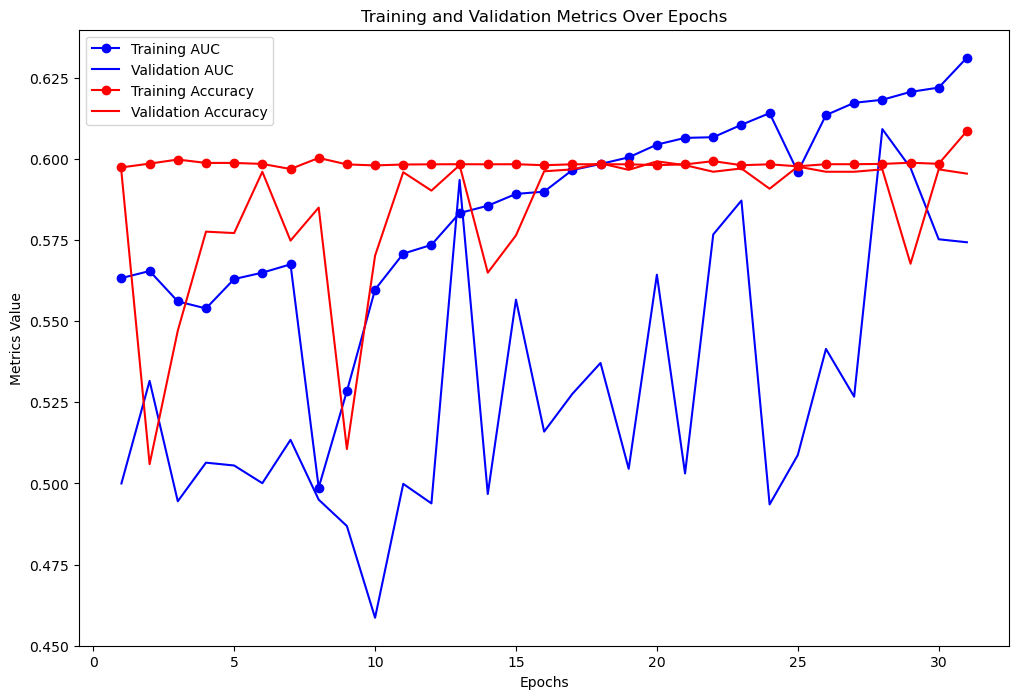

In [20]:
import matplotlib.pyplot as plt

# Extract epochs from the history
epochs = range(1, len(history.history['accuracy']) + 1)

# Extracting metrics from the history object using the correct keys
training_auc = history.history['AUC']
validation_auc = history.history['val_AUC']
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

# Create the plots
plt.figure(figsize=(12, 8))

plt.plot(epochs, training_auc, 'bo-', label='Training AUC')
plt.plot(epochs, validation_auc, 'b-', label='Validation AUC')
plt.plot(epochs, training_accuracy, 'ro-', label='Training Accuracy')
plt.plot(epochs, validation_accuracy, 'r-', label='Validation Accuracy')

plt.title('Training and Validation Metrics Over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Metrics Value')
plt.legend()

plt.show()


In [12]:
from keras_tuner.tuners import Hyperband

hypermodel = MyHyperModel(input_shape=(256, 256, 3))

tuner = Hyperband(
    hypermodel,
    objective='val_accuracy',  
    max_epochs=10,
    directory='my_dir',
    project_name='keras_tuner_resnet'
)


Reloading Tuner from my_dir/keras_tuner_resnet/tuner0.json


In [13]:
# Assume train_dataset and val_dataset are already defined and available
tuner.search(train_dataset, validation_data=val_dataset, epochs=10, callbacks=[tf.keras.callbacks.EarlyStopping(patience=1)])


Search: Running Trial #3

Value             |Best Value So Far |Hyperparameter
544               |544               |units
0.0013775         |0.0013775         |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2


Traceback (most recent call last):
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 274, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/base_tuner.py", line 239, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/tuners/hyperband.py", line 427, in run_trial
    return super().run_trial(trial, *fit_args, **fit_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
                ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
              ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/Users/arjunmoorthy/miniconda3/envs/torch/lib/python3.11/site-packages/keras/src/models/functional.py", line 280, in _adjust_input_rank
    raise ValueError(
ValueError: Exception encountered when calling Functional.call().

[1mInvalid input shape for input Tensor("data:0", shape=(None, 256, 256), dtype=float32). Expected shape (None, 256, 256, 3), but input has incompatible shape (None, 256, 256)[0m

Arguments received by Functional.call():
  • inputs=tf.Tensor(shape=(None, 256, 256), dtype=float32)
  • training=True
  • mask=None


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hyperparameters = tuner.get_best_hyperparameters(num_times=1)[0]

print('Best model summary:')
best_model.summary()
print('Best hyperparameters:', best_hyperparameters.values)

In [ ]:
# Calling the tuner_search function with the training and validation datasets
model, history = tuner_search(train_dataset, val_dataset)

# After tuning and training, evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")